In [25]:
import sacc
import numpy as np
import pyccl as ccl
import rosatX as rx
import pyatomdb
from astropy.io import fits
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Loading the data

In [26]:
rmf = fits.open('data/pspcb_gain2_256.rmf')
arf = fits.open('data/pspcb_gain2_256.arf')
cls_cov = sacc.Sacc.load_fits('data/cls_cov_y3.fits')

ROSAT, DESY3wl__3, cov = cls_cov.get_ell_cl('cl_0e','ROSAT', 'DESY3wl__3', return_cov=True)
err = np.sqrt(np.diagonal(cov))

## Initialising defaults and tracers

In [27]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102,
             "matter_power_spectrum": "linear"}

cosmo = ccl.Cosmology(**COSMO_P18)
mdef = ccl.halos.MassDef200c
cM = ccl.halos.ConcentrationDuffy08(mass_def=mdef)

dmat = ccl.halos.HaloProfileNFW(mass_def=mdef, concentration=cM)

nM = ccl.halos.MassFuncTinker08(mass_def=mdef)
bM = ccl.halos.HaloBiasTinker10(mass_def=mdef)
hmc = ccl.halos.HMCalculator(mass_function=nM,
                             halo_bias=bM,
                             mass_def=mdef,
                             log10M_max=15., log10M_min=10, nM=32)

# X-ray tracer
tx = rx.XrayTracer(cosmo)

zs = cls_cov.tracers['DESY3wl__3'].z
nz = cls_cov.tracers['DESY3wl__3'].nz

# gamma tracer
ts = ccl.WeakLensingTracer(cosmo, dndz=(zs, nz))

### Correcting for the smoothing

In [28]:
def pixel_FWHM(nside):
    """
    Returns the FWHM of the HEALPix pixel with nside = nside
    """
    fwhm_hp_amin =  60 * 41.7 / nside
    return np.radians(fwhm_hp_amin/60)/2.355

sigma_ROSAT = np.radians(1.8e0/60)/2.355
sigma_HEALPix = pixel_FWHM(1024)

sigma_tot_2 = sigma_ROSAT**2 + 2*sigma_HEALPix**2

def cl_smoothing_factor(ell):
    return np.exp(-0.5*sigma_tot_2*ell*(1+ell))

## Calculating the X-ray Spectrum

In [29]:
kTmin = 0.02
kTmax = 50.0
nkT = 32
zmax = 4.0
nz = 16
emin = 0.5
emax = 2.0

Zmetal = 0.3
Zs = np.ones(31)
Zs[3:] = Zmetal

rosat_spectrum = pyatomdb.spectrum.CIESession()
rosat_spectrum.set_response(rmf, arf)
rosat_spectrum.set_abund(np.arange(31, dtype=int), Zs)

J_tot = rosat_spectrum.return_integrated_spectrum_interp(kTmin, kTmax,
                                                         nkT, zmax, nz,
                                                         emin, emax)

J_cont = rosat_spectrum.return_integrated_spectrum_interp(kTmin, kTmax,
                                                          nkT, zmax, nz,
                                                          emin, emax,
                                                          dolines=False, dopseudo=False)

## Calculating the X-ray profiles

In [30]:
a = 1.
x = np.geomspace(0.001, 5, 128)
M = 1e14

r200 = mdef.get_radius(cosmo, M, a) / a
r = r200*x

# Battaglia

density_bg = rx.HaloProfileDensityBattaglia(mass_def=mdef, kind='n_total')

pressure_bg = rx.HaloProfilePressureBattaglia(mass_def=mdef, kind='n_total', kind_P='n_total')

x_bg = rx.HaloProfileXray(mass_def=mdef, J=J_tot, dens=density_bg, pres=pressure_bg,
                          fourier_approx=False,
                          with_clumping=True)


# Hydrostatic Equilibirum

density_he = rx.HaloProfileDensityHE(mass_def=mdef,
                                     concentration=cM,
                                     kind='n_total')
pressure_he = rx.HaloProfilePressureHE(mass_def=mdef,
                                       concentration=cM,
                                       kind='n_total')
x_he = rx.HaloProfileXray(mass_def=mdef,
                          J=J_tot,
                          dens=density_he,
                          pres=pressure_he,
                          fourier_approx=False,
                          with_clumping=True)
x_he_cont = rx.HaloProfileXray(mass_def=mdef,
                          J=J_cont,
                          dens=density_he,
                          pres=pressure_he,
                          fourier_approx=False,
                          with_clumping=True)

## Calculating the $P(k)$s and $C_\ell$s

In [31]:
k_arr = np.geomspace(1e-4,1e2,256)
a_arr = np.linspace(0.3,1,8)

ls = np.unique(np.geomspace(2, 3100, 128).astype(int)).astype(float)

# Battaglia
pk_bg = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=x_bg,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_bg = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_bg)

# Hydrostatic Equilibirum
pk_he = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=x_he,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_he = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he)

pk_he_cont = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=x_he_cont,
                               lk_arr=np.log(k_arr), a_arr=a_arr)
cl_he_cont = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_he_cont)

# NFW
#pk_nfw = ccl.halos.halomod_Pk2D(cosmo, hmc, dmat, prof2=x_nfw,
#                               lk_arr=np.log(k_arr), a_arr=a_arr)
#cl_nfw = ccl.angular_cl(cosmo, ts, tx, ls, p_of_k_a=pk_nfw)


# Add smoothing
cl_bg *= cl_smoothing_factor(ls)
cl_he *= cl_smoothing_factor(ls)
cl_he_cont *= cl_smoothing_factor(ls)
#cl_nfw *= cl_smoothing_factor(ls)

## Plots

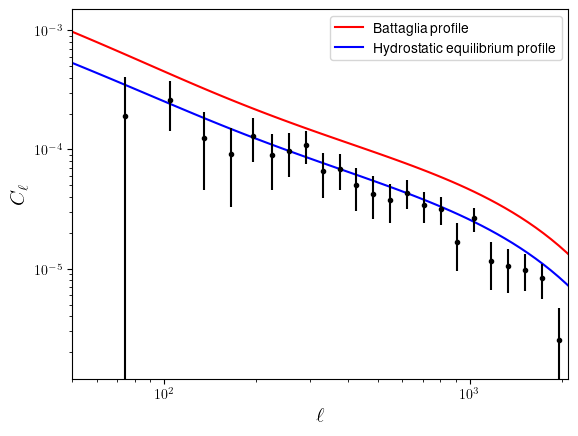

In [32]:
plt.plot(ls, cl_bg, 'r', label='Battaglia profile')
plt.plot(ls, cl_he, 'b', label='Hydrostatic equilibrium profile')
#plt.plot(ls, cl_nfw, 'g', label='NFW')
plt.errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.ylim([1.2e-6, 1.5e-3])
plt.xlim([50, 2100])

plt.legend();

plt.savefig('Plots/Cls_Battaglia_Comparison.pdf');

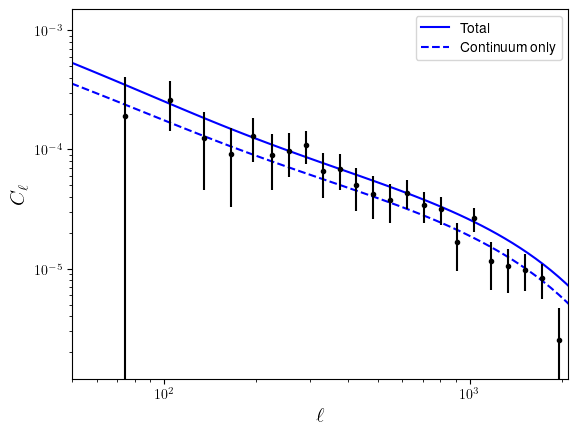

In [33]:
plt.plot(ls, cl_he, color=plt.cm.winter(0), label='Total')
plt.plot(ls, cl_he_cont, color=plt.cm.winter(0), linestyle='--', label='Continuum only')
plt.errorbar(ROSAT, DESY3wl__3, yerr=err, fmt='k.')
plt.loglog()
plt.xlabel(r'$\ell$', fontsize=15)
plt.ylabel(r'$C_\ell$', fontsize=15)
plt.ylim([1.2e-6, 1.5e-3])
plt.xlim([50, 2100])

plt.legend();

plt.savefig('Plots/Cls_HE_Comparison.pdf');